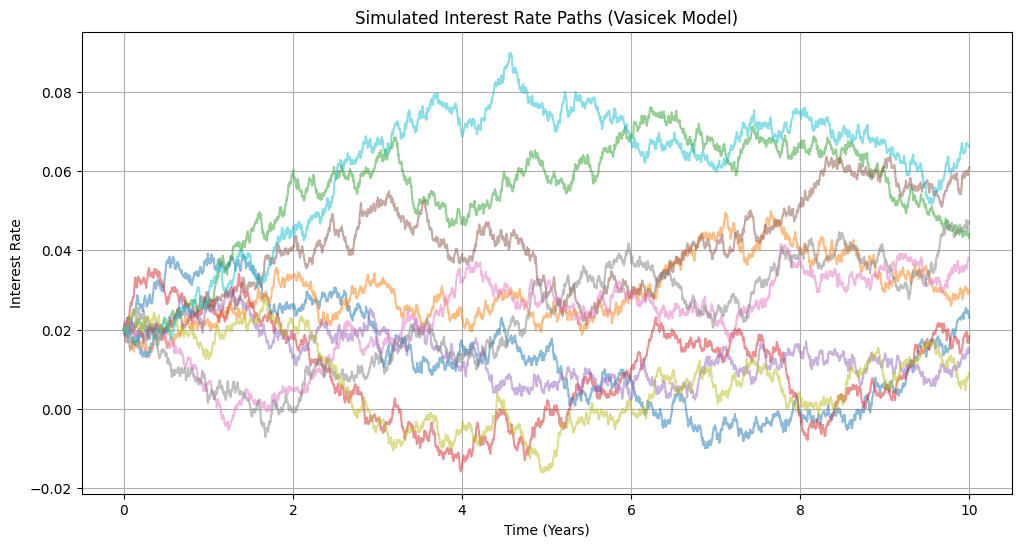

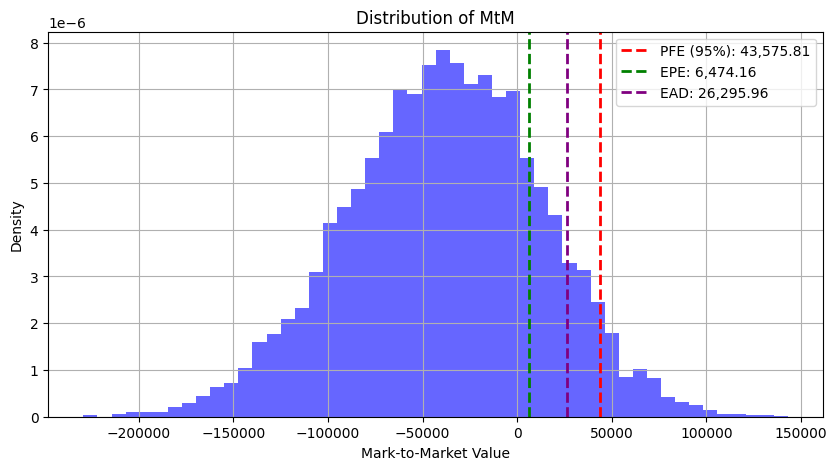

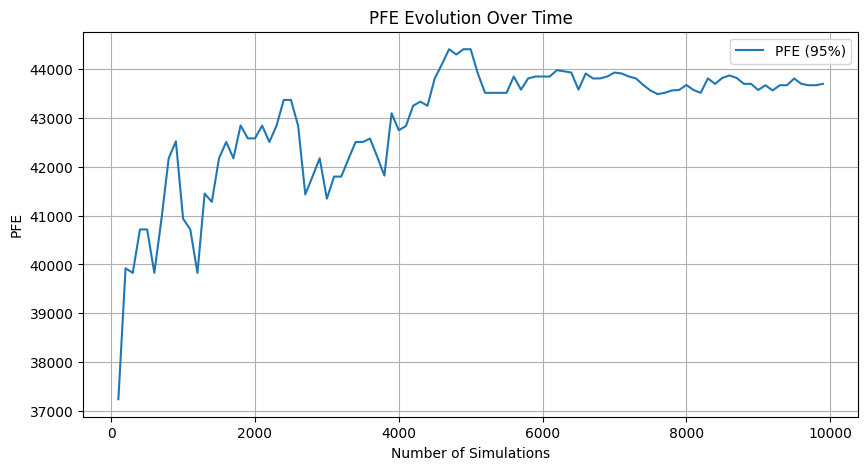

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import numba

# Parameters for Vasicek interest rate model
r0 = 0.02  # Initial rate
kappa = 0.1  # Mean reversion speed
theta = 0.03  # Long-term mean
sigma = 0.01  # Volatility
T = 10  # Years
dt = 1/252  # Daily steps
N = int(T / dt)  # Number of steps
M = 10000  # Number of simulations

@numba.njit
def simulate_vasicek(M, N, r0, kappa, theta, sigma, dt):
    rates = np.zeros((M, N))
    rates[:, 0] = r0
    for t in range(1, N):
        dW = np.sqrt(dt) * np.random.randn(M)
        rates[:, t] = rates[:, t-1] + kappa * (theta - rates[:, t-1]) * dt + sigma * dW
    return rates

# Simulate short rate paths
rates = simulate_vasicek(M, N, r0, kappa, theta, sigma, dt)

# Compute discount factors
B = np.exp(-np.cumsum(rates, axis=1) * dt)

# Simulate fixed and floating legs of an IRS (5-year maturity, annual payments)
fixed_rate = 0.03  # Fixed coupon rate
notional = 1e6  # Notional amount
time_to_maturity = int(5 / dt)
fixed_leg = fixed_rate * notional * np.sum(B[:, :time_to_maturity], axis=1) * dt
floating_leg = notional * (1 - B[:, time_to_maturity])

# Calculate MtM values
MtM = floating_leg - fixed_leg

# Compute risk metrics
PFE_95 = np.percentile(MtM, 95)
EPE = np.mean(np.maximum(MtM, 0))
EAD = np.percentile(np.maximum(MtM, 0), 90)  # Approximate EAD at 90%

# Plot interest rate evolution
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), rates[:10, :].T, alpha=0.5)
plt.title("Simulated Interest Rate Paths (Vasicek Model)")
plt.xlabel("Time (Years)")
plt.ylabel("Interest Rate")
plt.grid()
plt.show()

# Plot MtM distribution
plt.figure(figsize=(10, 5))
plt.hist(MtM, bins=50, density=True, alpha=0.6, color='b')
plt.axvline(PFE_95, color='r', linestyle='dashed', linewidth=2, label=f"PFE (95%): {PFE_95:,.2f}")
plt.axvline(EPE, color='g', linestyle='dashed', linewidth=2, label=f"EPE: {EPE:,.2f}")
plt.axvline(EAD, color='purple', linestyle='dashed', linewidth=2, label=f"EAD: {EAD:,.2f}")
plt.title("Distribution of MtM")
plt.xlabel("Mark-to-Market Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

# PFE evolution over time
PFE_over_time = [np.percentile(MtM[:i], 95) for i in range(100, M, 100)]
plt.figure(figsize=(10, 5))
plt.plot(range(100, M, 100), PFE_over_time, label="PFE (95%)")
plt.title("PFE Evolution Over Time")
plt.xlabel("Number of Simulations")
plt.ylabel("PFE")
plt.legend()
plt.grid()
plt.show()

